# Project 3

In [ ]:
# Name: ÖMER BAHADIR KUNDAK -- EGE MERİÇ ERDOĞAN
# ID  : 17243510020         -- 17243510026

In [ ]:
from bs4 import BeautifulSoup
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
from selenium import webdriver
from selenium.webdriver.common.by import By
def getDriver():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver',options=chrome_options)
  return driver

     |████████████████████████████████| 958 kB 5.1 MB/s 
     |████████████████████████████████| 356 kB 62.7 MB/s 
     |████████████████████████████████| 138 kB 61.8 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 3.6 MB 52.3 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/

<h2 style="color:red"> Question 1. In this project, you will scrape a web site to get the information of the books.</h2>

<h3 style="color:cyan">
a) In the first part, you will scrape a web site. 
</h3>

<p>
The web site is "https://www.idefix.com". You will get the information of the books in "Bilim" category.
In short, you can use "https://www.idefix.com/kategori/Kitap/Bilim/grupno=00052?Page=1" as a link.
In the "Bilim" category, there are 2437 books in 68 pages as I am preparing this project. 
</p>


<p>
First you need to find the links of the pages, then you can get the book links from these pages.After getting the link of each book, you can extract the information.You should get the values of "name", "author", "price", "number of reviwers", "rate given by the reviewers", "publication year" and "number of pages". Be careful, there may be missing values. After collecting the data, you need to store them in a file, preferably json.
</p>

<p>
You need to use Selenium, BeautifulSoup for scraping.
</p>



In [ ]:

from threading import Thread, Barrier, Semaphore

urls = []

maxthreads = 5
sema = Semaphore(value=maxthreads)
threads = list()


def findMaxPage():
  driver = getDriver()
  driver.get("https://www.idefix.com/kategori/Kitap/Bilim/grupno=00052?Page=1")
  pager = driver.find_element(By.XPATH,"/html/body/div/section/div/div[2]/div[1]/div[5]/div/div[3]/div[3]/ul/li[6]/a")
  return int(pager.text)

def getBooksUrlsByPage(page):
  sema.acquire()
  print("GET page/",page)
  driver = getDriver()
  driver.get("https://www.idefix.com/kategori/Kitap/Bilim/grupno=00052?Page="+str(page))
  books = driver.find_element(By.ID,"facetProducts") 
  books.find_element(By.CLASS_NAME,"shelf")
  books = books.find_element(By.CLASS_NAME, "row")
  booksUrl = books.find_elements(By.CLASS_NAME, "product-image")
  for url in booksUrl:
    urls.append(url.get_attribute("href"))
  driver.close()
  sema.release()
  return urls


#executes with 5 threads
maxPage = findMaxPage() + 1

for i in range(1,maxPage):
  t = Thread(target=getBooksUrlsByPage, args=(i,)) 
  threads.append(t)
  t.start()

for thread in threads:
  thread.join()
 
print(urls)





In [ ]:

import json
def createBaseFile(filename='data.json'):
  with open(filename,'w+') as file:
        json.dump([], file, indent = 4)
def write_json(new_data, filename='data.json'):
  with open(filename,'r+') as file:
    file_data = json.load(file)
    file_data.append(new_data)
    file.seek(0)
    json.dump(file_data, file, indent = 4)

createBaseFile("urls.json")
createBaseFile("data.json") # book infos will be writed to this file (data.json)
write_json(urls,"urls.json") #w rite urls to this file (urls.json)


In [ ]:

maxthreads = 3
sema = Semaphore(value=maxthreads)
threads = list()
boookInfos = []
ct = 1

def getBookInfoByUrl(url):
  global ct
  print("GET book:",ct)
  ct+=1
  try:
    driver = getDriver()
    driver.get(url)
    bookInfTable = driver.find_element(By.XPATH,"/html/body/div/section/div/div[2]/section[2]/div[2]/div/div/div/div/div/div[1]/div").text
    bookInfTable = bookInfTable.split("\n")
    bookInfo = {}
    for i,val in enumerate(bookInfTable):
      bookInfTable[i] = val.split(": ")
      bookInfo.update({bookInfTable[i][0]:bookInfTable[i][1]})

    IncelemeSayisi = driver.find_element(By.XPATH,"/html/body/div/section/div/div[2]/section[2]/div[1]/div/div/div[3]/div[2]/div[1]/div[2]/span/span[3]").text
    Puan = driver.find_element(By.XPATH,"/html/body/div/section/div/div[2]/section[2]/div[1]/div/div/div[3]/div[2]/div[1]/div[2]/span/span[1]").text
    price = driver.find_element(By.XPATH, "//*[@id=\"salePrice\"]").text
    bookInfo.update({"puan":Puan})
    bookInfo.update({"revCt":IncelemeSayisi})
    bookInfo.update({"price":price})
    driver.close()
    bookInfos.append(bookInfo)
    print(bookInfo)
    sema.release()
  except:
    driver.close()
    return {"error":url}
  return bookInfo
  
  

bookInfos = []
threads = []


for i in urls:
  write_json(getBookInfoByUrl(i))



In [ ]:
write_json(bookInfos)

# Analyzing the retrieved Objects
 - data.json => books' information




<h3 style="color:cyan">
b) In the second part, you will use statistical and probability tools to understand data.. 
</h3>

<p>
You need the find mean and median and stdev values of the book prices.
You need to draw the histogram of the reviewers' number. Use discrete values such as 10,20 on the x-axis.
You need to find out if there is a relationship between between the book price and the book rate.
You need to find the distribution of the words and the most used word in the book names. You can draw a histogram.
</p>


In [ ]:
!wget http://egemeric.gen.tr/dataFinal.json  # to get datafiles get the prepared dataset. because of file size(1mb) google colab doesnt uploads the file
import json
import numpy as np
import pandas as pd
from locale import atof, setlocale, LC_NUMERIC
setlocale(LC_NUMERIC, "")
def getBooksData():
  with open("dataFinal.json",'r+') as file:
      file_data = json.load(file)
  return file_data[0]

bookData = getBooksData()
for i,data in enumerate(bookData):
  if(data.get("error")):
    bookData.pop(i)

row = [["Kitap Adı", "Yazar", "Sayfa Sayısı", "İlk Baskı Yılı", "puan","revCt", "price"]]

for book in bookData: # filter data
  kitap = book.get("Kitap Adı")
  yazar = book.get("Yazar")
  if(book.get("Sayfa Sayısı")):
    try:
      sayfa = int(book.get("Sayfa Sayısı"))
    except:
      sayfa = np.NaN
  else:
    sayfa = np.NaN
  if(book.get("İlk Baskı Yılı")):
    yil = int(book.get("İlk Baskı Yılı"))
  else:
    yil = np.NaN
  incelemeSayi = int(book.get("revCt"))
  if incelemeSayi == 0:
    puan = np.NaN
  else:
    puan = float(book.get("puan").replace(",","."))
  price = book.get("price").replace(",",".")
  price = price.split(" ")[0]
  if len(price.split(".")) > 2:
    price = price.split(".")
    price = price[0]+price[1] + "."+price[2]
  price = float(price)
  one_row = [kitap,yazar,sayfa,yil,puan,incelemeSayi,price]
  row.append(one_row)

pd.set_option('display.max_columns', None)
df = pd.DataFrame(row[1::], columns = row[0])
print(df)
  


--2022-01-05 12:30:56--  http://egemeric.gen.tr/dataFinal.json
Resolving egemeric.gen.tr (egemeric.gen.tr)... 94.177.246.8
Connecting to egemeric.gen.tr (egemeric.gen.tr)|94.177.246.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1251211 (1.2M) [application/json]
Saving to: ‘dataFinal.json’

dataFinal.json      100%[===================>]   1.19M   796KB/s    in 1.5s    

2022-01-05 12:30:58 (796 KB/s) - ‘dataFinal.json’ saved [1251211/1251211]

                                       Kitap Adı                  Yazar  \
0                         Bilim Tarihi Durakları       Şeniz Yıldırımer   
1                             Tehlikeli Tırmanış         Hakan Bulgurlu   
2                       Safsatalar Ansiklopedisi  Immanuel Tolstoyevski   
3                         Ağaçların Gizli Yaşamı        Peter Wohlleben   
4                                           Kaos           James Gleick   
...                                          ...                    ...   

# Analayze the filtered data

In [ ]:
print("Statistics of all books price")
print(df["price"].describe())
print("\nStatistics of all books pt")
print(df["puan"].describe())
print("\nStatistics of all books year")
print(df["İlk Baskı Yılı"].describe())
print("\nStatistics of all books revievers")
print(df["revCt"].describe())
print("\nStatistics of all books revievers")
print(df["Sayfa Sayısı"].describe())




Statistics of all books price
count    2355.000000
mean       45.026624
std        92.387614
min         3.250000
25%        23.535000
50%        32.850000
75%        46.220000
max      2116.500000
Name: price, dtype: float64

Statistics of all books pt
count    889.000000
mean       4.123735
std        0.994857
min        0.000000
25%        4.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: puan, dtype: float64

Statistics of all books year
count    2311.000000
mean     2015.477715
std         5.560163
min      1984.000000
25%      2013.000000
50%      2017.000000
75%      2020.000000
max      2021.000000
Name: İlk Baskı Yılı, dtype: float64

Statistics of all books revievers
count    2355.000000
mean        2.163057
std         9.540981
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       212.000000
Name: revCt, dtype: float64

Statistics of all books revievers
count     660.000000
mean      283.872727
std       180.66

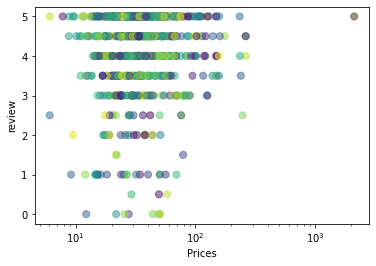

when rates gets higer prices gets higher


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats
from scipy.stats import norm

bookPrices = df["price"]
bookRevievs = df["puan"]
maxPrice=max(bookPrices)

slope, intercept,r,*__ = scipy.stats.linregress(bookPrices,bookRevievs)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig,ax = plt.subplots()

colors = np.random.rand(len(bookPrices))
plt.scatter(bookPrices, bookRevievs, s=50, c=colors, alpha=0.5)
ax.set_xscale('log')
plt.xlabel("Prices")
plt.ylabel("review")
plt.show()
print("when rates gets higer prices gets higher")

Book name words: ['bilim', 'tarihi', 'durakları', 'tehlikeli', 'tırmanış', 'safsatalar', 'ansiklopedisi', 'ağaçların', 'gizli', 'yaşamı', 'kaos', 'keyif', 'verici', 'maddelerin', 'tarihi', 'holografik', 'evren', 'astronomi', 'for', 'dummies', 'homo', 'narrans', 'i̇nsan', 'vücuduna', 'seyahat', 'arılarla', 'dans', 'bir', 'doğaya', 'dönüş', 'yolculuğu', 'beyinde', 'ararken', 'bağırsakta', 'buldum', 'dünyalıların', 'geleceği', 'i̇nsanlığın', 'tarihöncesinin', 'sonu', 'uygarlaşan', 'i̇ştah', 'yeni', 'dünyanın', 'cesur', 'i̇nsanı', 'vicdan', 'i̇nsan', 'çevre', 'toplum', 'yeni', 'bilim', 'bilim', 'devrimcileri', 'altı', 'kolay', 'parça', 'dura', 'mater', 'anatomi', '101', 'bir', 'çırpıda', 'i̇nsan', 'vücud', 'bitkilerin', 'bildikleri', 'matematiğin', 'kısa', 'tarihi', 'siyasal', 'antropoloji', 'yeni', 'dünya', 'yeni', 'ağ', 'hiperuzay', 'arachnoid', 'mater', 'medeniyetlerin', 'şafağı', "akdeniz'i", 'n', 'öyküsü', 'permakültür', 'uygulamaları', 'türlerin', 'kökeni', 'feynman', 'fizik', 'dersl

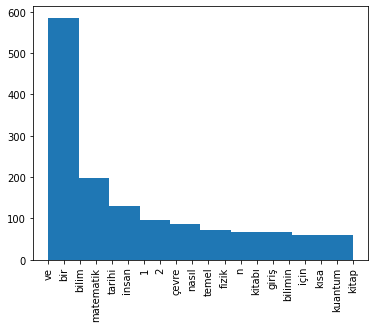

In [ ]:
import re
bookNames = df["Kitap Adı"]
words = []
for name in bookNames:
  for word in re.compile("([\w][\w]*'?\w?)").findall(name):
    words.append(word.lower())
print("Book name words:",words)
word_ct = Counter(words)
print("Word counts:",word_ct)
mostCommon = word_ct.most_common(20)
print("Most common 20 word at book names:",mostCommon)

x = [i[0] for i in mostCommon]
y = [i[1] for i in mostCommon]
print(x,"\n",y)

plt.hist(x,bins=None, weights=y)
plt.xticks(x, x, rotation ='vertical')
plt.subplots_adjust(bottom = 0)
plt.show()



# Question 2. Assigning features and label variables
# First Feature
sports=['Football', 'Football', 'Tenis', 'Basketball', 'Basketball', 'Basketball', 'Tenis', 'Football', 'Football', 'Basketball', 'Football', 'Tenis', 'Tenis', 'Basketball']
# Second Feature
instruments=['Guitar','Guitar','Guitar','Piano','Cello','Cello','Cello','Piano','Cello','Piano','Piano','Piano','Guitar','Piano']

# Label or target variable
play=['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']
# Question 2 
a. Visualize the data

b. Train the model using the training sets via K-NN algorithm when the k is 3 and 5 respectively.

c. Predict the target value of  'Tenis, Piano'  when the k is 3 and 5.

Zipped Features: [(1, 1), (1, 1), (2, 1), (0, 2), (0, 0), (0, 0), (2, 0), (1, 2), (1, 0), (0, 2), (1, 2), (2, 2), (2, 1), (0, 2)]
instruments_encoded: [1 1 1 2 0 0 0 2 0 2 2 2 1 2]
Labels(play): [0 0 1 1 1 0 1 0 1 1 1 1 1 0]
(1, 1) 0
(1, 1) 0
(2, 1) 1
(0, 2) 1
(0, 0) 1
(0, 0) 0
(2, 0) 1
(1, 2) 0
(1, 0) 1
(0, 2) 1
(1, 2) 1
(2, 2) 1
(2, 1) 1
(0, 2) 0
Predicted Output when KNN equals 3 is: [1]
Predicted Output when KNN equals 5 is: [1]


<Figure size 432x288 with 0 Axes>

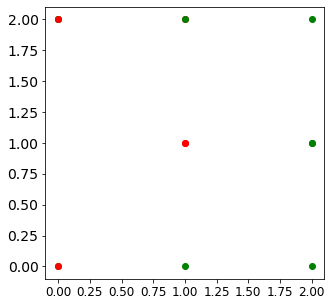

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt

sports=['Football', 'Football', 'Tenis', 'Basketball', 'Basketball', 'Basketball', 'Tenis', 'Football', 'Football', 'Basketball', 'Football', 'Tenis', 'Tenis', 'Basketball']
instruments=['Guitar','Guitar','Guitar','Piano','Cello','Cello','Cello','Piano','Cello','Piano','Piano','Piano','Guitar','Piano']
play=['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
sports_encoded=le.fit_transform(sports)
# converting string labels into numbers
instruments_encoded=le.fit_transform(instruments)
labels=le.fit_transform(play)
features=list(zip(sports_encoded,instruments_encoded))
play_dataset=zip(features,labels)
print("Zipped Features:",features)
print("instruments_encoded:",instruments_encoded)
print("Labels(play):",labels)

plt.figure()
plt.figure(figsize=(5,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)


for target, label in play_dataset:
    print(target, label)
    if label==0:
        plt.scatter(target[0], target[1] , c = 'red')
    else: 
        plt.scatter(target[0], target[1] , c = 'green')


# When KNN == 3 
model1 = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model1.fit(features,labels)

#Predict Output
predicted1= model1.predict([[2,2]]) # 2:tennis, 2:piano
print("Predicted Output when KNN equals 3 is:", predicted1)


# When KNN == 5
model2 = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model2.fit(features,labels)

#Predict Output
predicted2= model2.predict([[2,2]]) # 2:tennis, 2:piano
print("Predicted Output when KNN equals 5 is:", predicted2)